In [ ]:
import torch
from torch import nn
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2

In [ ]:
!git clone https://github.com/ladofa/edu

Cloning into 'edu'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 108 (delta 36), reused 38 (delta 3), pack-reused 0
Receiving objects: 100% (108/108), 33.43 MiB | 8.06 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Updating files: 100% (40/40), done.


In [ ]:
root = 'edu/samples/kakao-color/'

#학습 데이터 준비

In [ ]:
x_images = []
y_images = []

for i in range(10):
    x_filename = root+'colormap_%d.png' % i
    y_filename = root+'w%d.jpg' % i
    x_image = cv2.imread(x_filename).reshape(-1, 3)
    x_images.append(x_image)
    y_image = cv2.imread(y_filename).reshape(-1, 3)
    y_images.append(y_image)

In [ ]:
x_pixels = np.concatenate(x_images, axis=0)
y_pixels = np.concatenate(y_images, axis=0)
rand_idx = np.random.permutation(len(x_pixels))
x_train = torch.tensor(x_pixels[rand_idx], dtype=torch.float32) / 127.5 - 1
y_train = torch.tensor(y_pixels[rand_idx], dtype=torch.float32) / 127.5 - 1

In [ ]:
#참고...
# mean = x_train.mean(axis=0)
# std = x_train.std(axis=0)
# x_train_scaled = (x_train - mean) / std
# x_train_scaled[:10]

tensor([[-0.2606, -0.5454, -0.9495],
        [ 1.3354,  1.6984, -0.9495],
        [-1.1769, -1.2816, -0.3604],
        [ 0.0448,  0.8103,  0.0225],
        [ 1.3354,  1.1725, -0.9495],
        [-0.5759, -1.2816, -0.1248],
        [ 1.2172, -0.6622, -0.9495],
        [-0.9207, -1.2816,  1.5540],
        [ 1.3354,  1.6751,  1.2006],
        [-1.1769, -1.2816,  0.8177]])

In [ ]:
x_valid = torch.tensor(cv2.imread(root+'test.jpg').reshape(-1, 3), dtype=torch.float32) / 127.5 - 1
y_valid = torch.tensor(cv2.imread(root+'test_w.jpg').reshape(-1, 3), dtype=torch.float32) / 127.5 - 1

In [ ]:
# from numpy.random.mtrand import shuffle
batch_size = 8192
dataset_train = torch.utils.data.TensorDataset(x_train, y_train) #zip 기능 포함
loader_train = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size, shuffle=True)
len(loader_train)

320

In [ ]:
#test...
for item in loader_train:
    print(item[1].shape)
    break

torch.Size([8192, 3])


In [ ]:
#test...
mini_dataset = torch.utils.data.Subset(dataset_train, range(5))
for item in mini_dataset:
    print(item)

(tensor([162.,  84.,   0.]), tensor([179., 110.,  61.]))
(tensor([255.,  82., 255.]), tensor([129.,  88., 156.]))
(tensor([ 0.,  0., 54.]), tensor([28., 22., 27.]))
(tensor([255., 203., 255.]), tensor([227., 221., 240.]))
(tensor([223., 194.,   0.]), tensor([209., 187.,  92.]))


#일반적 딥러닝 모델

In [ ]:
torch.cuda.is_available()

True

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
class Scale(nn.Module):
    def forward(self, input):
        return input / 127.5 - 1

class Unscale(nn.Module):
    def forward(self, input):
        z = input * 127.5 + 127.5
        return torch.clip(z, 0, 255)

model = nn.Sequential(
    # Scale(),
    nn.Linear(3, 8),
    nn.Tanh(),
    nn.Linear(8, 8),
    nn.Tanh(),
    nn.Linear(8, 3),
    # Unscale()
).to(device)

In [ ]:
model

Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): Tanh()
  (4): Linear(in_features=8, out_features=3, bias=True)
)

In [ ]:
summary(model, (3,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              32
              Tanh-2                    [-1, 8]               0
            Linear-3                    [-1, 8]              72
              Tanh-4                    [-1, 8]               0
            Linear-5                    [-1, 3]              27
Total params: 131
Trainable params: 131
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
opt = torch.optim.AdamW(model.parameters())
loss_fn = nn.MSELoss()

In [ ]:
model.to(device)

Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): Tanh()
  (4): Linear(in_features=8, out_features=3, bias=True)
)

In [ ]:
for epoch in range(30):
    #train
    for step, (x, y) in enumerate(loader_train):
        pred = model(x.to(device))
        loss = loss_fn(pred, y.to(device))
        opt.zero_grad()
        # for param in model.parameters():
        #     param.grad = None
        loss.backward()
        opt.step()
        np_loss = loss.to('cpu').detach().numpy()
        print(f'\r[{epoch}]{step} loss={np_loss:.4f}', end='')
    #valid
    with torch.no_grad():
        pred = model(x_valid.to(device)).to('cpu')
        loss = loss_fn(pred, y_valid).numpy()
        print(f'     val_loss={loss:.4f}')

[0]319 loss=0.0154     val_loss=0.0079
[1]319 loss=0.0100     val_loss=0.0053
[2]319 loss=0.0085     val_loss=0.0053
[3]319 loss=0.0074     val_loss=0.0050
[4]319 loss=0.0062     val_loss=0.0047
[5]319 loss=0.0051     val_loss=0.0044
[6]319 loss=0.0044     val_loss=0.0043
[7]319 loss=0.0040     val_loss=0.0038
[8]319 loss=0.0037     val_loss=0.0037
[9]319 loss=0.0033     val_loss=0.0036
[10]319 loss=0.0032     val_loss=0.0036
[11]319 loss=0.0029     val_loss=0.0036
[12]319 loss=0.0029     val_loss=0.0036
[13]319 loss=0.0027     val_loss=0.0037
[14]319 loss=0.0027     val_loss=0.0038
[15]319 loss=0.0026     val_loss=0.0038
[16]319 loss=0.0025     val_loss=0.0038
[17]319 loss=0.0024     val_loss=0.0038
[18]319 loss=0.0024     val_loss=0.0037
[19]319 loss=0.0022     val_loss=0.0036
[20]319 loss=0.0021     val_loss=0.0035
[21]319 loss=0.0020     val_loss=0.0033
[22]319 loss=0.0020     val_loss=0.0032
[23]319 loss=0.0019     val_loss=0.0031
[24]319 loss=0.0018     val_loss=0.0031
[25]319 lo

In [ ]:
!wget https://file.mk.co.kr/meet/neds/2022/08/image_readtop_2022_761383_16617354415150451.jpg -O newjeans.jpg

--2023-02-06 01:19:18--  https://file.mk.co.kr/meet/neds/2022/08/image_readtop_2022_761383_16617354415150451.jpg
Resolving file.mk.co.kr (file.mk.co.kr)... 222.239.240.19, 211.110.63.99
Connecting to file.mk.co.kr (file.mk.co.kr)|222.239.240.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129336 (126K) [image/jpeg]
Saving to: ‘newjeans.jpg’

newjeans.jpg        100%[===================>] 126.30K   341KB/s    in 0.4s    

2023-02-06 01:19:20 (341 KB/s) - ‘newjeans.jpg’ saved [129336/129336]



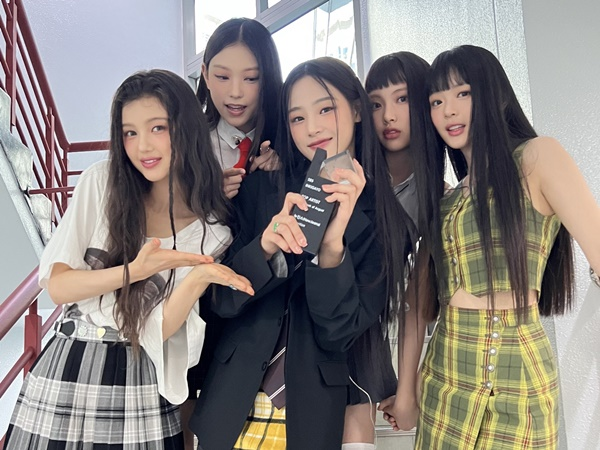

In [ ]:
image = cv2.imread('newjeans.jpg')
cv2_imshow(image)

In [ ]:
model.to('cuda')
model.eval()

Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): Tanh()
  (4): Linear(in_features=8, out_features=3, bias=True)
)

In [ ]:
input.shape

torch.Size([270000, 3])

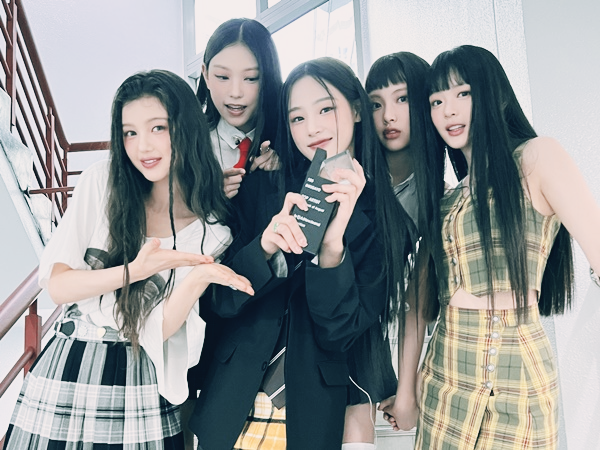

In [ ]:
with torch.no_grad():
    input = image.reshape(-1, 3)
    input = torch.tensor(input)
    input = input.type(torch.float32) / 127.5 - 1
    input = input.to(device)
    output = model(input)
    output = output * 127.5 + 127.5
    output = output.to('cpu').numpy()
    output = np.clip(output, 0, 255).astype(np.uint8)
    output = output.reshape(image.shape)

cv2_imshow(output)

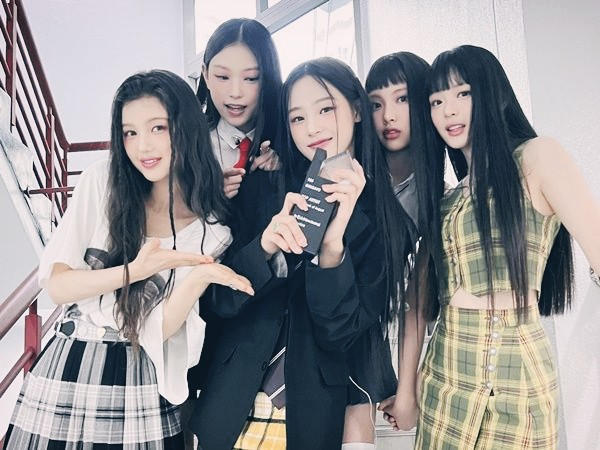

In [ ]:
valid_image = cv2.imread('newjeans_winter.jpg')
cv2_imshow(valid_image)


In [ ]:
class FinalModel(nn.Module):
    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model

    def forward(self, image):
        input = image.reshape(-1, 3)
        input = input.type(torch.float32) / 127.5 - 1
        output = model(input)
        output = output * 127.5 + 127.5
        output = torch.clip(output, 0, 255).type(torch.uint8)
        output = output.reshape(image.shape)
        return output
final_model = FinalModel(model)

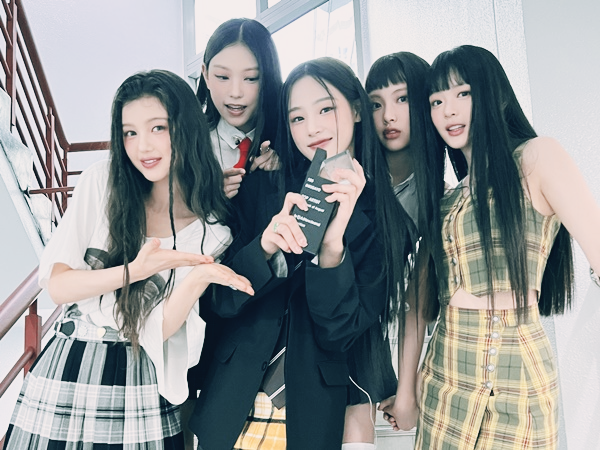

In [ ]:
image = cv2.imread('newjeans.jpg')
# final_model.to('cuda')
output = final_model(torch.tensor(image).to(device)).to('cpu').numpy()
cv2_imshow(output)

In [ ]:
torch.save({
            'model': model.state_dict(),
            'final_model': final_model.state_dict(),
            }, 'winter_multi.pt')

In [ ]:
test_image = cv2.imread(root+'test.jpg')

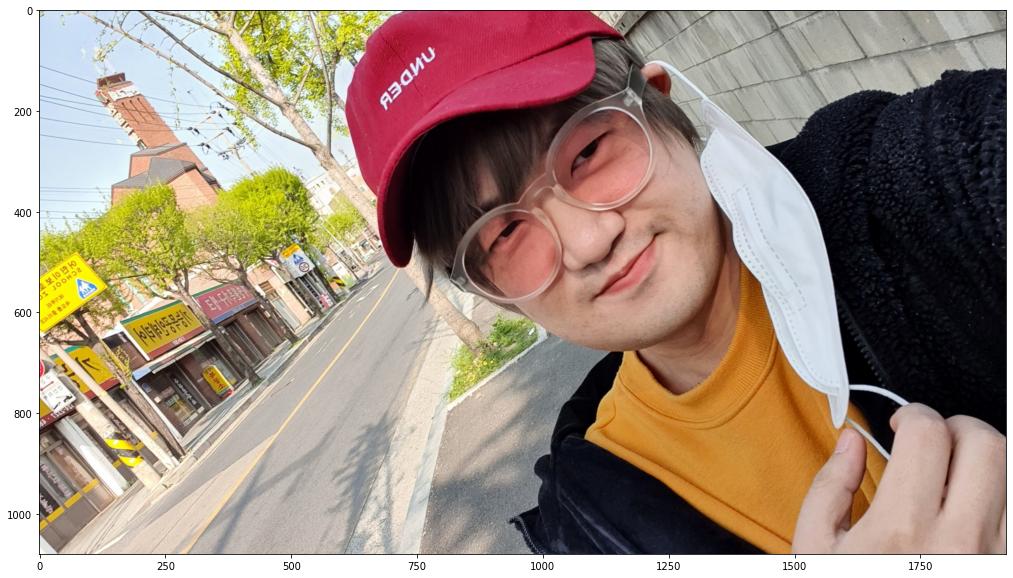

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(test_image[..., [2, 1, 0]])

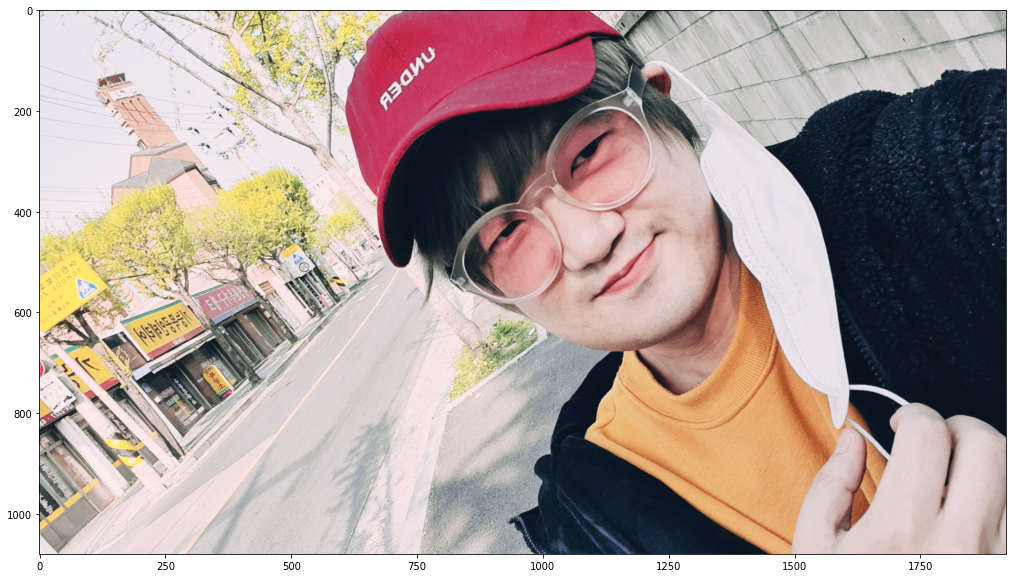

In [ ]:
dst = final_model(torch.tensor(test_image[None]))[0].numpy()
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

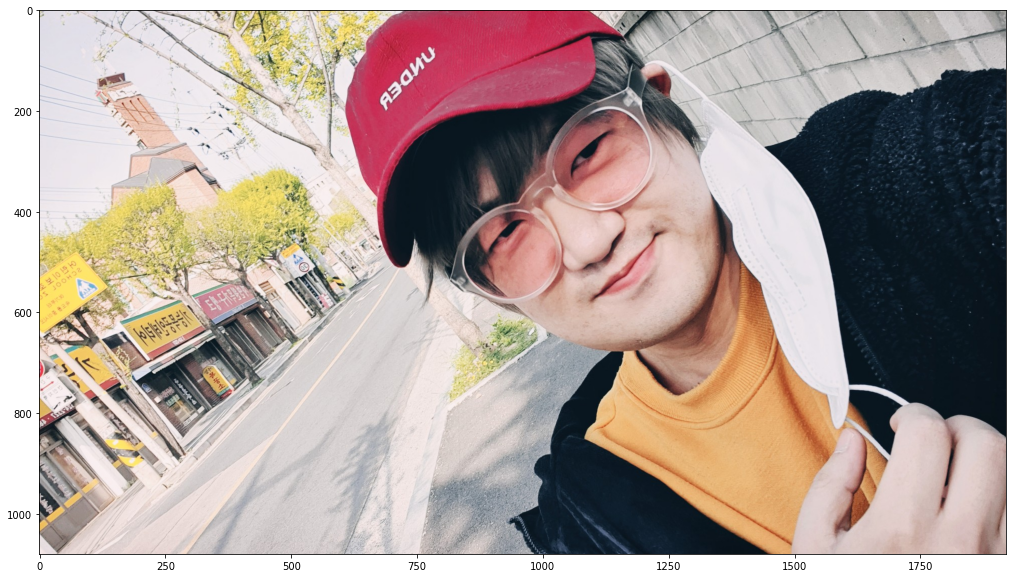

In [ ]:
test_image_w = cv2.imread(root+'test_w.jpg')
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(test_image_w, cv2.COLOR_BGR2RGB))